## augmentation 
- resize to a n * n dimension, using squished method (stretched)
- randomize: brightness, zoom, warp when rotated, and flip

## model
efnet b0, b5 then assemble

## training method
fastai with efficient + progressive training + fp16
then progressively trained from 128, 256, 368, 468 with 64,64,64,32,16 batch size respectively

## loss function 
FocalLoss -> label smoothing cross entropy


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
from fastai.vision.models.efficientnet import *

import torch

torch.cuda.empty_cache()

In [2]:
#masukkin image dataset nya disini, tapi per folder harus ada labelnya
#Reference Implementation fastai --->>> https://gilberttanner.com/blog/fastai-image-classification
defaults.device = torch.device("cuda")

In [3]:
def get_data(bs, size): 
    tfms = get_transforms(max_lighting=0.4, max_zoom=1.2, max_warp=0.2, max_rotate=20, xtra_tfms=[flip_lr()])
    return ImageDataBunch.from_folder(Path('./dataset'),
                                  train = 'train/',
                                  valid_pct = 0.1,
                                  resize_method=ResizeMethod.SQUISH, 
                                  ds_tfms = tfms,
                                  size = size,
                                  bs = bs,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)

# 1. 128

In [4]:
data = get_data(64, 128)

len(data.classes), data.c

(42, 42)

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b0')
# model

Loaded pretrained weights for efficientnet-b0


In [6]:
model._fc = nn.Linear(model._fc.in_features, data.c)

In [ ]:
from efficientnet_pytorch import EfficientNet

def get_model(pretrained=True, **kwargs): 
    model = EfficientNet.from_pretrained('efficientnet-b0')
    model._fc = nn.Linear(model._fc.in_features, data.c) # check the top most layer
    return model 

def stage1(learn, data=None, epoch = 5):
    if data: 
        learn.data=data
        learn.to_fp16()
        
    learn.freeze()
    learn.fit_one_cycle(epoch)
    
def stage2(learn, load_filename=None, epoch=5):
    if load_filename: 
        learn.load(load_filename, purge=True)
    learn.unfreeze()
    learn.lr_find()
    learn.recorder.plot(suggestion=True)
    min_grad_lr = learn.recorder.min_grad_lr
    learn.fit_one_cycle(epoch, slice(min_grad_lr/40, min_grad_lr))

learn = Learner(data, model,
               metrics = [accuracy], 
                bn_wd=False, #disable weight decay 
                loss_func = LabelSmoothingCrossEntropy(), 
                callback_fns=[BnFreeze,
                             partial(SaveModelCallback, monitor='accuracy', name='most_accurate')],
               path='./dataset').to_fp16() # because different clf layer, we use Learner.
learn.split(lambda m: (model._conv_head,))

In [ ]:
stage1(learn)


In [ ]:
stage2(learn)

In [ ]:
learn.save('b5-epoch5-128')
learn.load('b5-epoch5-128', purge=True)



# 2. 256

In [ ]:
data = get_data(64, 256)
learn.load('b5-epoch5-256', purge=True)
learn.to_fp16()
stage1(learn, data)
stage2(learn)

In [ ]:
learn.save('b5-epoch5-256')
learn.load('b5-epoch5-256', purge=True)


# 3. 368

In [ ]:
# SINI
data = get_data(32, 368)
learn.load('b0-epoch5-384', purge=True)
learn.to_fp16()
stage1(learn, data)
stage2(learn)

In [ ]:
learn.save('b5-epoch5-368')

# 4. 468

In [ ]:
# SINI
data = get_data(32, 368)
learn.load('b0-epoch5-384', purge=True)
learn.to_fp16()
stage1(learn, data)
stage2(learn)

In [ ]:
learn.save('b5-epoch5-468')

# 5. 512

In [ ]:
# learn.load('b5-epoch5-468', purge=True)
data = get_data(16, 512)
learn.load('b5-epoch5-468', purge=True)
learn.data=data
learn.to_fp16()
stage1(learn, data)
stage2(learn,epoch=6)

In [ ]:
learn.save('b0 final ')
learn.export('b0')

In [ ]:
data = get_data(16, 512)
learn.load('b0 final ', purge=True)
learn.data = data
learn.to_fp16()
stage1(learn,epoch=6)
learn.save('b0 final-1')

In [9]:
import os
os.system('python finish_me.py')

0

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


epoch,train_loss,valid_loss,accuracy,time
0,1.359770,1.179092,0.868678,49:36
1,1.318135,1.176489,0.869342,49:55
2,1.296440,1.175781,0.870671,49:57
3,1.336471,1.175156,0.869722,49:06
4,1.310309,1.174974,0.871240,49:06


Better model found at epoch 0 with accuracy value: 0.8686782717704773.
Better model found at epoch 1 with accuracy value: 0.8693424463272095.
Better model found at epoch 2 with accuracy value: 0.8706708550453186.
Better model found at epoch 4 with accuracy value: 0.8712401390075684.


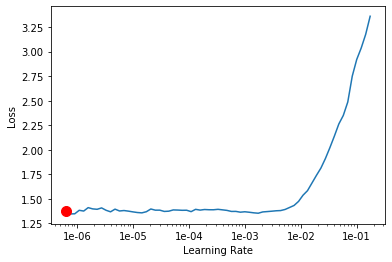

In [8]:
# learn.load('b5-epoch5-468', purge=True)
# stage1(learn, data)
learn.load('b0 final-1', purge=True)
data = get_data(16, 512)

learn.data=data
learn.to_fp16()

stage2(learn,epoch=5)

In [9]:
import os
os.system('python finish_me.py')

0

In [ ]:
def make_submission(learn, filename):
    log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test)
    preds = np.argmax(log_preds, 1)
    a = np.array(preds)
    submission = pd.DataFrame({'image_name': os.listdir('data/test'), 'label': a})
    submission.to_csv(path/filename, index=False)